## Why Feature Visualization ?

A Convolutional Neural Network has a number of layers in its network and each of these layers helps in extracting the features of the images and classify the object in the image. Now, once we built a neural net, there are circumstances when our nn fails to classify the image like dog from cat. So to understand what the each of these layers have learnt from those images, we should visualize the features generated by the neural net.

### Feature Maps

At the beginning of the CNN, there are number of kernels/filters which learns features from the input image and outputs a filtered version of the image. Each of these kernels are initialized randomly and as the neural net pass through the feedforward and backpropagation phase, it learns to create filter which learns the pattern in the image. As it turns out, the learned filter is nothing but a high pass filter.

In [16]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from IPython.display import Image


In [3]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the test data
print('Test data, number of images: ', len(test_data))

Test data, number of images:  10000


In [4]:
batch_size = 20

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        ## output size = (W-F)/S +1 = (28-3)/1 +1 = 26
        # the output Tensor for one image, will have the dimensions: (10, 26, 26)
        # after one pool layer, this becomes (10, 13, 13)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(2, 2)
        
        # second conv layer: 10 inputs, 20 outputs, 3x3 conv
        ## output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # the output tensor will have dimensions: (20, 11, 11)
        # after another pool layer this becomes (20, 5, 5); 5.5 is rounded down
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # 20 outputs * the 5*5 filtered/pooled map size
        self.fc1 = nn.Linear(20*5*5, 50)
        
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        
        # finally, create 10 output channels (for the 10 classes)
        self.fc2 = nn.Linear(50, 10)

    # define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # prep for linear layer
        # this line of code is the equivalent of Flatten in Keras
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x

In [6]:
# instantiate your Net
net = Net()

# load the net parameters by name
net.load_state_dict(torch.load('/Users/mayurjain/Desktop/cnn_fashion.pt'))

print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


First convolutional layer


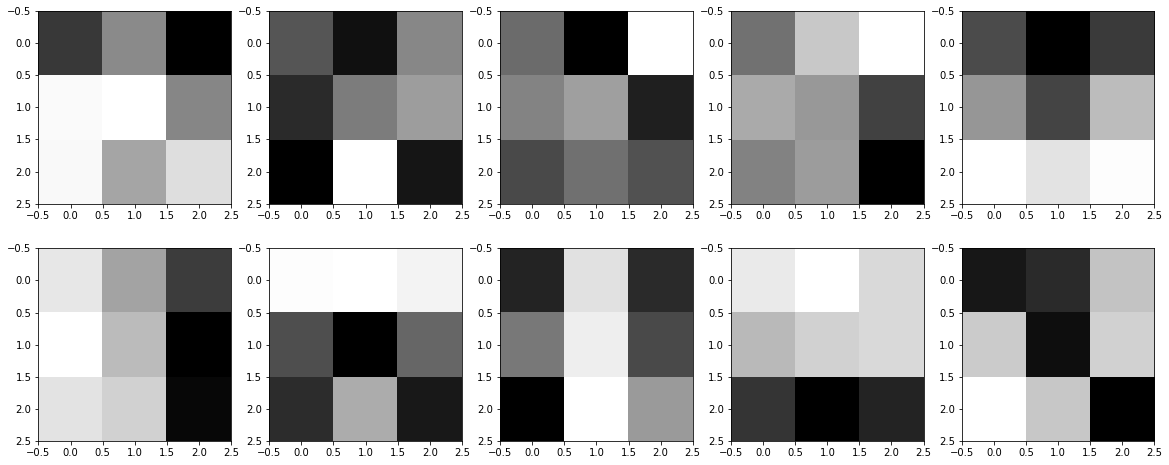

In [9]:
# Get the weights in the first conv layer
weights = net.conv1.weight.data
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

weights = net.conv2.weight.data
w = weights.numpy()

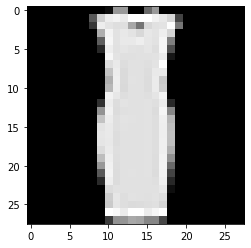

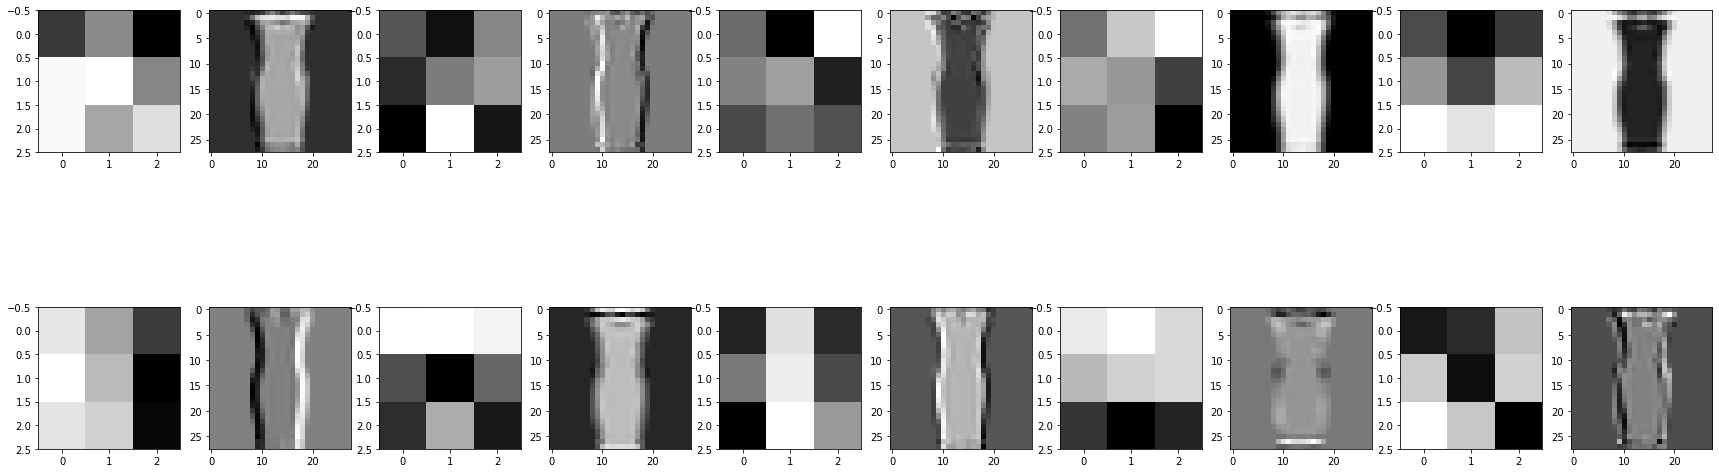

In [14]:
# obtain one batch of testing images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 10
img = np.squeeze(images[idx])

# Use OpenCV's filter2D function 
# apply a specific set of filter weights (like the one's displayed above) to the test image

import cv2
plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
w = weights.numpy()

# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

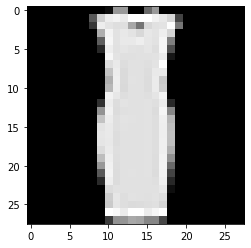

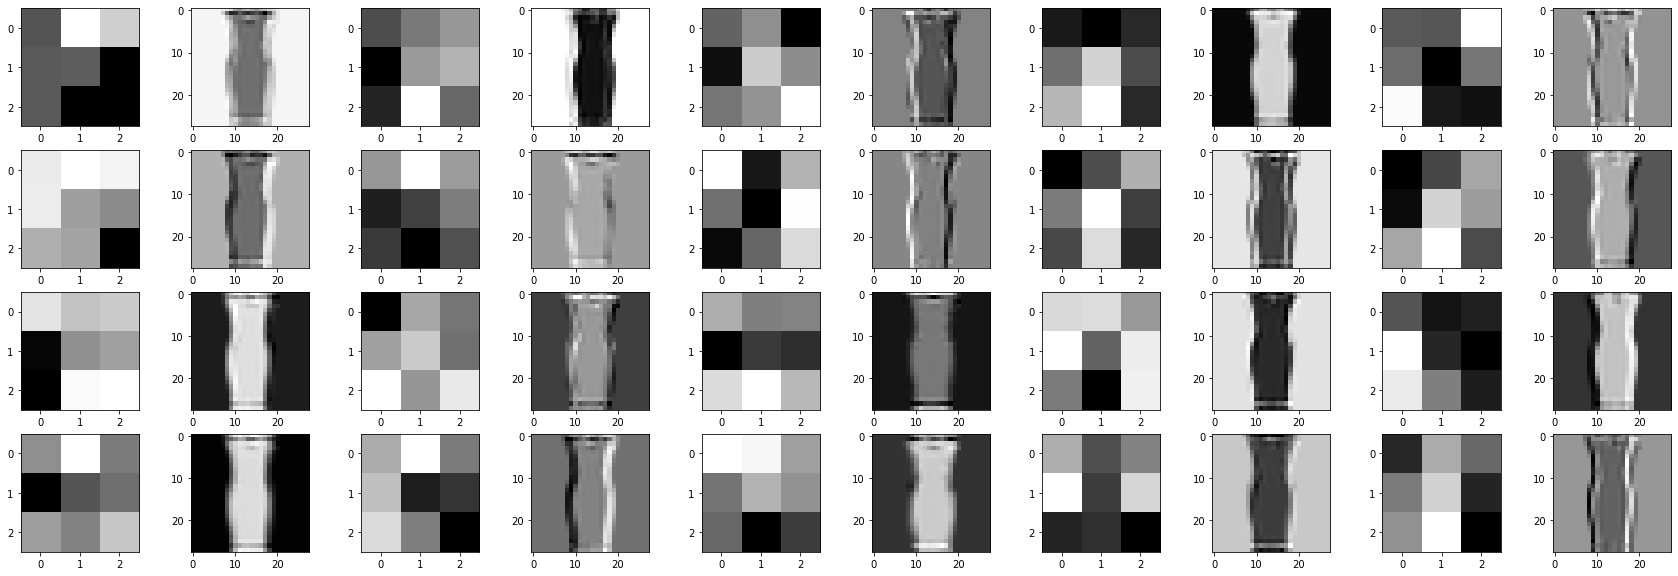

In [15]:
# Same process but for the second conv layer (20, 3x3 filters):
plt.imshow(img, cmap='gray')

# second conv layer, conv2
weights = net.conv2.weight.data
w = weights.numpy()

# 1. first conv layer
# for 20 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2*2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

## Occlusion Experiments
Occlusion means to block out or mask part of an image or object. For example, if you are looking at a person but their face is behind a book; this person's face is hidden (occluded). Occlusion can be used in feature visualization by blocking out selective parts of an image and seeing how a network responds.

The process for an occlusion experiment is as follows:

    * Mask part of an image before feeding it into a trained CNN,
    * Draw a heatmap of class scores for each masked image,
    * Slide the masked area to a different spot and repeat steps 1 and 2.
    * The result should be a heatmap that shows the predicted class of an image as a function of which part of an image was occluded. The reasoning is that if the class score for a partially occluded image is different than the true class, then the occluded area was likely very important!

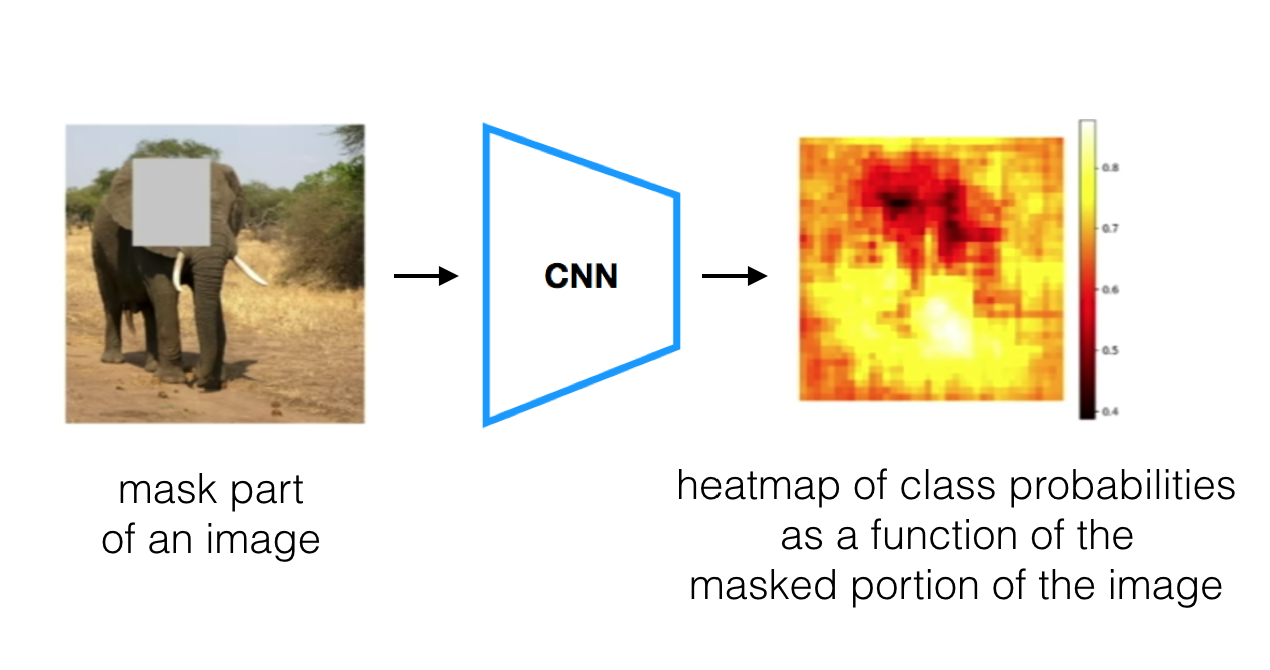

In [17]:
Image(filename='/Users/mayurjain/Desktop/cv_images/Occlusion.png')

## Saliency Maps
Salience can be thought of as the importance of something, and for a given image, a saliency map asks: Which pixels are most important in classifying this image?

Not all pixels in an image are needed or relevant for classification. In the image of the elephant above, you don't need all the information in the image about the background and you may not even need all the detail about an elephant's skin texture; only the pixels that distinguish the elephant from any other animal are important.

Saliency maps aim to show these important pictures by computing the gradient of the class score with respect to the image pixels. A gradient is a measure of change, and so, the gradient of the class score with respect to the image pixels is a measure of how much a class score for an image changes if a pixel changes a little bit.

### Measuring change

A saliency map tells us, for each pixel in an input image, if we change it's value slightly (by dp), how the class output will change. If the class scores change a lot, then the pixel that experienced a change, dp, is important in the classification task.

Looking at the saliency map below, you can see that it identifies the most important pixels in classifying an image of a flower. These kinds of maps have even been used to perform image segmentation (imagine the map overlay acting as an image mask)!

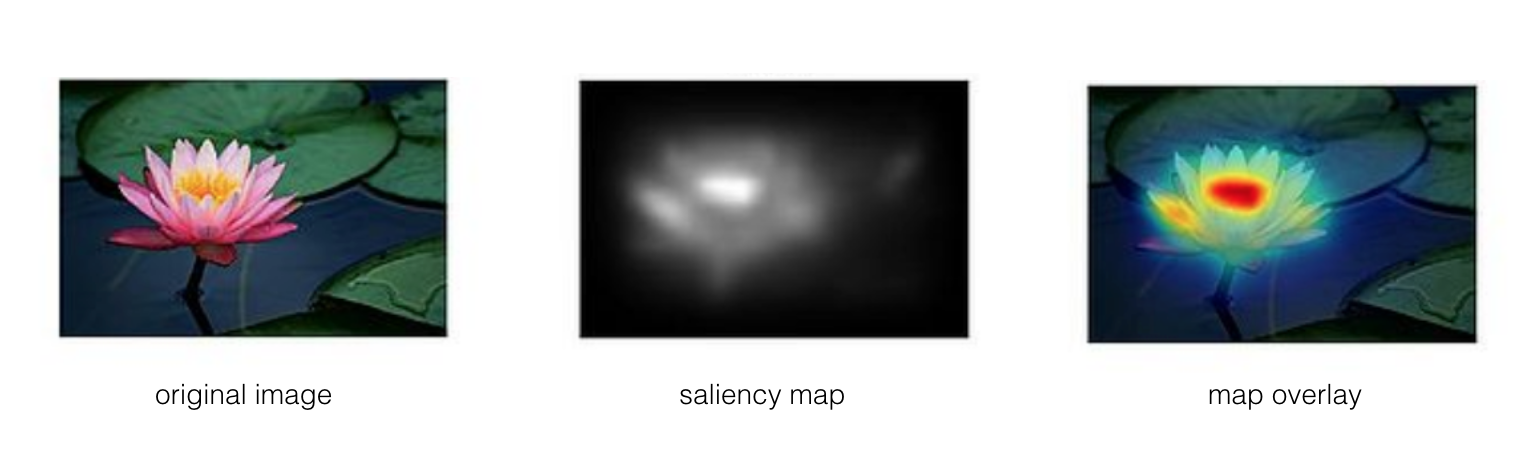

In [18]:
Image(filename='/Users/mayurjain/Desktop/cv_images/Saliency.png')

## Guided Backpropagation
Similar to the process for constructing a saliency map, you can compute the gradients for mid level neurons in a network with respect to the input pixels. Guided backpropagation looks at each pixel in an input image, and asks: if we change it's pixel value slightly, how will the output of a particular neuron or layer in the network change. If the expected output change a lot, then the pixel that experienced a change, is important to that particular layer.

This is very similar to the backpropagation steps for measuring the error between an input and output and propagating it back through a network. Guided backpropagation tells us exactly which parts of the image patches, that we’ve looked at, activate a specific neuron/layer.



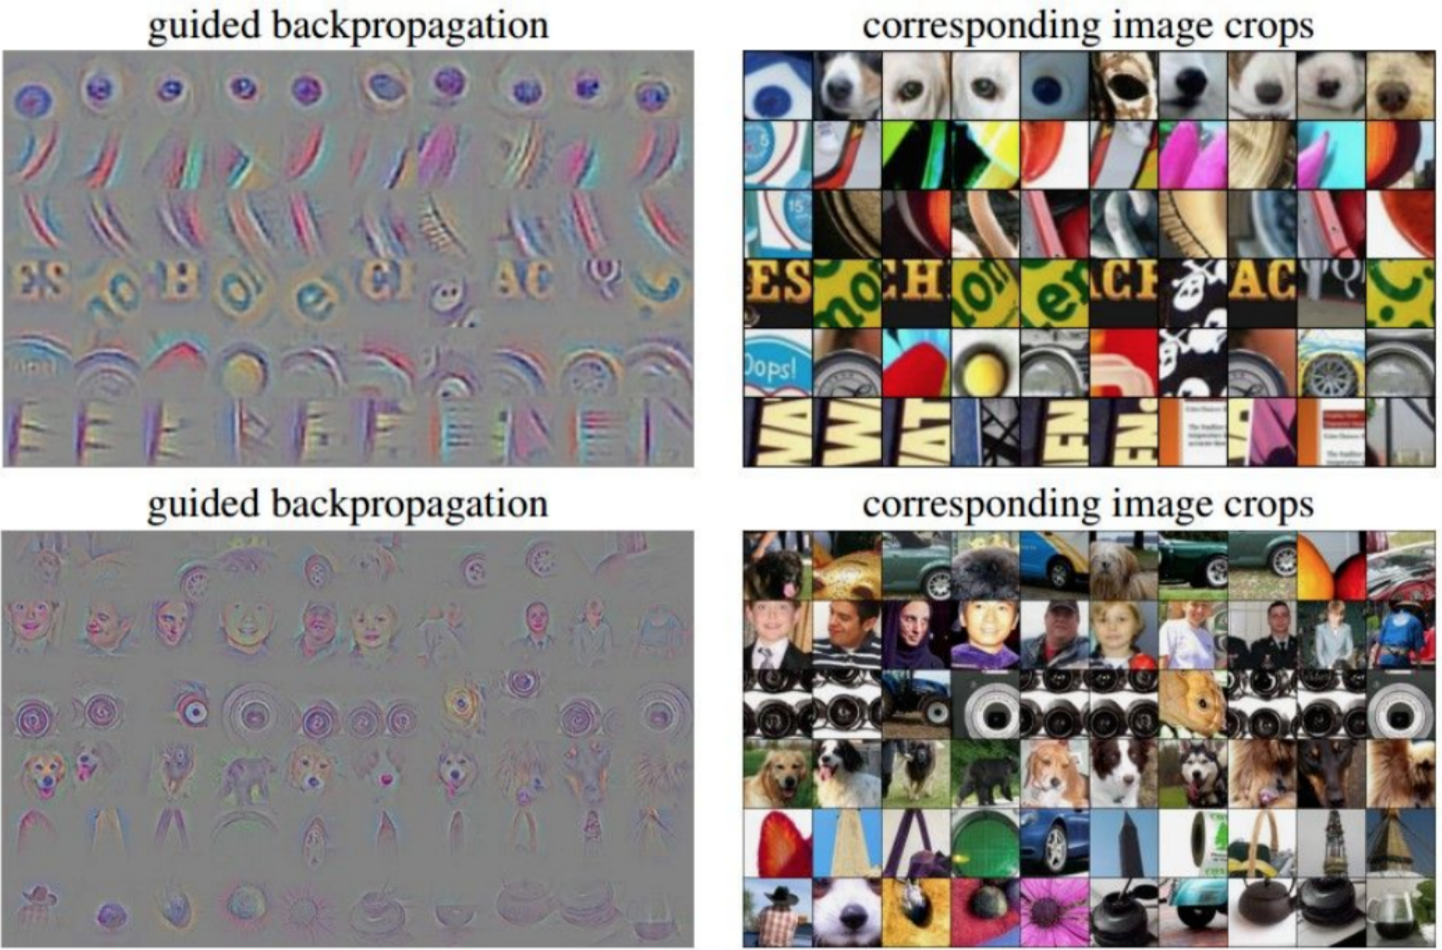

In [19]:
Image(filename='/Users/mayurjain/Desktop/cv_images/GBP.png')

## Deep Dream
DeepDream takes in an input image and uses the features in a trained CNN to amplifying the existing, detected features in the input image! The process is as follows:

Choose an input image, and choose a convolutional layer in the network whose features you want to amplify (the first layer will amplify simple edges and later layers will amplify more complex features).
Compute the activation maps for the input image at your chosen layer.
Set the gradient of the chosen layer equal to the activations and and use this to compute the gradient image.
Update the input image and repeat!
In step 3, by setting the gradient in the layer equal to the activation, we’re telling that layer to give more weight to the features in the activation map. So, if a layer detects corners, then the corners in an input image will be amplified, and you can see such corners in the upper-right sky of the mountain image, below. For any layer, changing the gradient to be equal to the activations in that layer will amplify the features in the given image that the layer is responding to the most.

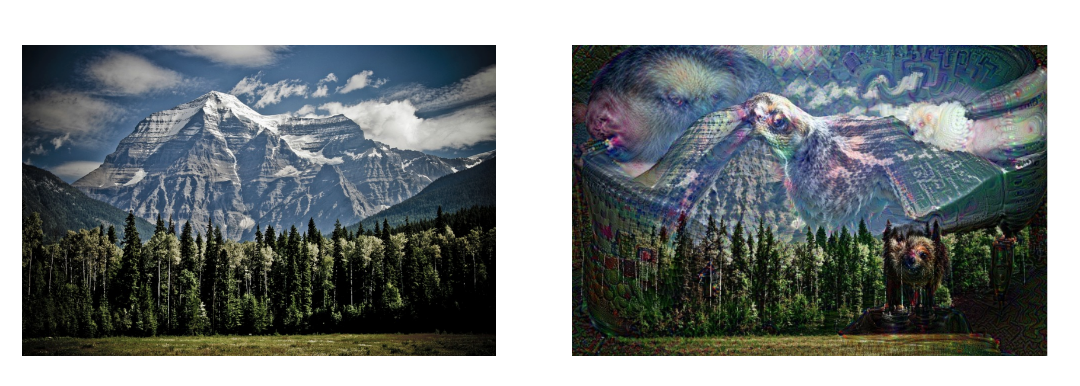

In [20]:
Image(filename='/Users/mayurjain/Desktop/cv_images/deepDream.png')

## Style Transfer
Style transfer aims to separate the content of an image from its style. So, how does it do this?

#### Isolating content

When Convolutional Neural Networks are trained to recognize objects, further layers in the network extract features that distill information about the content of an image and discard any extraneous information. That is, as we go deeper into a CNN, the input image is transformed into feature maps that increasingly care about the content of the image rather than any detail about the texture and color of pixels (which is something close to style).

You may hear features, in later layers of a network, referred to as a "content representation" of an image.

#### Isolating style

To isolate the style of an input image, a feature space designed to capture texture information is used. This space essentially looks at the correlations between feature maps in each layer of a network; the correlations give us an idea of texture and color information but leave out information about the arrangement of different objects in an image.

#### Combining style and content to create a new image

Style transfer takes in two images, and separates the content and style of each of those images. Then, to transfer the style of one image to another, it takes the content of the new image and applies the style of an another image (often a famous artwork).

The objects and shape arrangement of the new image is preserved, and the colors and textures (style) that make up the image are taken from another image. Below you can see an example of an image of a cat [content] being combined with the a Hokusai image of waves [style]. Effectively, style transfer renders the cat image in the style of the wave artwork.

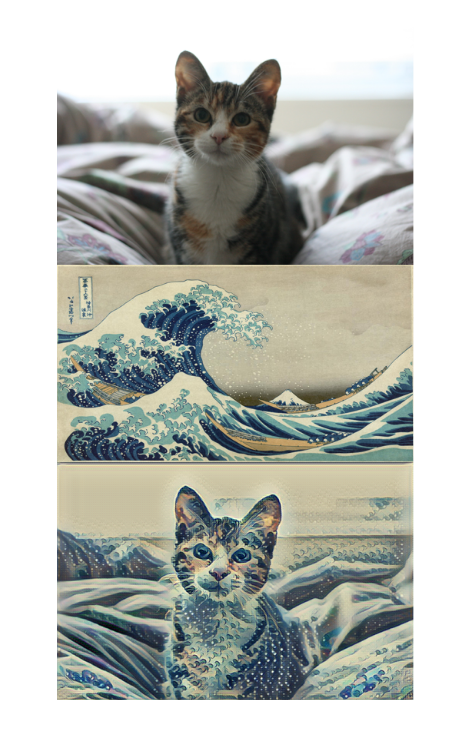

In [21]:
Image(filename='/Users/mayurjain/Desktop/cv_images/styletransfer.png')